# **Interval Replacements of Persistence Modules**

In this tutorial notebook, we focus on a specific example of (quiver) representation, also called persistence module, to illustrate how to compute its interval replacement using the provided code in the **utils.py** file. Some visualization features from **display.py** are available in 1D or 2D settings. Note that all the computations should be valid for any d-dimensional grid with $d \ge 1$.

In this tutorial you will see how to:
- **define a representation** object ;
- **define intervals** of this representation ;
- **compute interval ranks and interval signed multiplicities**, which yield the interval replacement of the representation.

# Setup: import

All the necessary code to compute interval replacements can be found in the **utils.py** file. The **display.py** file contains some functions to help visualizing representations of 1D or 2D grids.

In [1]:
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from utils import *
from display import display_rep, display_interval
from matplotlib.ticker import MaxNLocator

# Part I: Core Objects

### 1) Create a grid and define a representation

We will use the 2D grid example from the paper (Example 7.2) as our running example. You are welcome to explore your own quiver or representation.

Note: in what follows we will consider $\mathbb{k} = \mathbb{R}$. If necessary, you can modify the code to compute path evaluations, interval ranks, and interval replacements in finite fields for example.

First, we can create an instance of the *Representation* class as follows, by specifying the dimensions of the underlying quiver.

In [2]:
dimensions = [1, 5]  # 2D grid 2x5
R = Representation(dimensions)

We can now visualize the representation thanks to **display_rep**. 

In [3]:
display_rep(R)

.          .          .          .          .


At the moment, the representation is a 2x5 grid with no vector space. We can add vector spaces manually.

In [4]:
# manually add vector spaces
R.create_vecs((0, 0), 1) # (position, vector space's dimension)
R.create_vecs((0, 1), 2)
R.create_vecs((0, 2), 3)
R.create_vecs((0, 3), 3)
R.create_vecs((0, 4), 2)

In [5]:
display_rep(R)

1          2          3          3          2


Note that, relative to the conventions in the paper, the vertical direction of the quiver arrows is flipped (they point downward rather than upward). This convention is more convenient for computer implementations.

Now that we successfully added all the vector spaces, we can specify linear maps.

In [6]:
# first define parameter lambda

la = 1
 
# our implementation also handles symbolic calculations
# try to uncomment the following line to obtain symbolic results that depend on lambda:
#la = sp.symbols('lambda')

# manually add linear maps u: x -> y
R.create_matrix((0, 0), (0, 1), sp.Matrix([[1],[0]])) # (x, y, matrix), for matrices equal to 0 you can directly write None
R.create_matrix((0, 1), (0, 2), sp.Matrix([[1,0],[0,1],[0,0]]))
R.create_matrix((0, 2), (0, 3), sp.eye(3))
R.create_matrix((0, 3), (0, 4), sp.Matrix([[0,1,0],[0,0,1]]))

In [7]:
display_rep(R)

1 -------> 2 -------> 3 -------> 3 -------> 2


Once we have specified all the matrices, we can now evaluate $L(\rho)$, given a path $\rho: x \rightarrow y$.

In [8]:
R.evaluation((0,1), (0,2)) # (x, y)

Matrix([
[1, 0],
[0, 1],
[0, 0]])

This evaluation attribute will be useful to compute interval ranks and interval signed multiplicities. But first, we need to define intervals.

### 2) Define intervals

We can define intervals by providing a list of sources and a list of sinks.

In [9]:
itv1 = Interval([(0,2)], [(0,4)]) # (sources, sinks)

Let us display the interval.

In [10]:
display_interval(R, itv1)

.          .          X -------> X -------> X


Note that the intervals are defined through their sources and their sinks. If needed, you can access all the points in the interval with the **int_hull** attribute.

In [11]:
R.int_hull(itv1)

[(0, 2), (0, 3), (0, 4)]

Conversely, given a list of points forming a convex and connected set, we can create an Interval object with **get_src_snk**:

In [12]:
points = [(0, 2), (0, 3), (0, 4)]
src, snk =  R.get_src_snk(points)
itv2 = Interval(src,snk)
display_interval(R, itv2)

.          .          X -------> X -------> X


You can access the list of all intervals with **list_int**.

In [13]:
intervals = R.list_int(conv=False)

By **[1, Theorem 31]**, we know that the number of intervals should be equal to $\sum\limits_{w=1}^5 \sum\limits_{h=1}^2 \frac{(3-w+1)(3-h+1)}{h+w-1} \binom{h+w-1}{h-1}\binom{h+w-1}{w-1}$.

In [14]:
import math
m = 2
n = 5
S = 0
for w in range(1,m+1):
    for h in range(1,n+1):
        S += (m-w+1)*(n-h+1)/(h+w-1)*math.comb(h+w-1,h-1)*math.comb(h+w-1,w-1)
print(int(S))

100


The number of intervals is indeed equal to 100 here:

In [15]:
print(len(intervals))

15


# Part II: Computing Interval Ranks, Interval Replacements, and Interval Multiplicities

### 0) Important note when using symbolic calculation (la = sp.symbols('lambda'))

When working with symbolic lambda parameters rather than fixed numerical values, we need to ensure that substituting specific numerical values into our symbolic results matches what we would get by building the representation with those numerical values directly.

However, this direct substitution does not always work seamlessly. The interval rank and interval replacement computation depends on matrix rank calculations, which can behave discontinuously. This means the underlying algebraic structure actually changes at certain special parameter values, making simple substitution unreliable at these singular points.

Our next step is to systematically identify these singular parameter values where the symbolic computation breaks down. For these special cases, we could compute the interval ranks and interval replacements numerically to obtain the correct results.

In [16]:
if R.has_symbols(): # used to check if R has any symbolic parameter
    
    # find singularities
    singularities = R.find_complete_singularities(la)

    print(f"""
    For λ ∉ {singularities}:
    - Symbolic interval rank/replacement computations are valid
    - Simple substitution λ → gives correct results
    - Algebraic structure remains constant

    For λ ∈ {singularities}:
    - Algebraic structure changes at these parameter values  
    - Symbolic computation cannot be trusted via simple substitution
    - Interval ranks/replacements must be computed numerically for each singularity
    """)

else:
    print("No symbolic calculation.")

No symbolic calculation.


Note that the cell above computes singularities globally: it checks for singularities across all possible computations in the representation and aggregates them.

### 1) Interval ranks

We can directly compute the $I$-rank of $R$ using **int_rank** as follows.

Note that, by default, the $\rm tot$ compression system is used. If you prefer to use the $\rm ss$ compression system, you can specify it.

In [17]:
display(R.int_rank(itv1, compression="ss"))

# optional: add this when doing symbolic calculation to print singularities 
if R.has_symbols():
    print(f"Valid if λ ∉ {R.singularities}")

2

We can compute all interval ranks under tot or ss, and display the nonzero ones.

In [18]:
for itv in intervals:
        
    irank = R.int_rank(itv, compression='ss')
    if irank != 0:
        print(f"Interval: src={itv.src}, snk={itv.snk}")
        print()
        display_interval(R,itv)
        print()
        print("Interval rank:")
        print()
        print()
        sp.pprint(irank)
        if R.has_symbols():
            print(f"Valid if λ ∉ {R.singularities}")
        print("="*60)

Interval: src=[(0, 0)], snk=[(0, 0)]

X          .          .          .          .

Interval rank:


1
Interval: src=[(0, 1)], snk=[(0, 1)]

.          X          .          .          .

Interval rank:


2
Interval: src=[(0, 2)], snk=[(0, 2)]

.          .          X          .          .

Interval rank:


3
Interval: src=[(0, 3)], snk=[(0, 3)]

.          .          .          X          .

Interval rank:


3
Interval: src=[(0, 4)], snk=[(0, 4)]

.          .          .          .          X

Interval rank:


2
Interval: src=[(0, 0)], snk=[(0, 1)]

X -------> X          .          .          .

Interval rank:


1
Interval: src=[(0, 1)], snk=[(0, 2)]

.          X -------> X          .          .

Interval rank:


2
Interval: src=[(0, 2)], snk=[(0, 3)]

.          .          X -------> X          .

Interval rank:


3
Interval: src=[(0, 3)], snk=[(0, 4)]

.          .          .          X -------> X

Interval rank:


2
Interval: src=[(0, 0)], snk=[(0, 2)]

X -------> X -------> X   

We can summarize the result and visualize it by utilizing the connected persistence diagrams. We refer to [5] for details.

Note that the visualization can NOT be implemented for symbolic computation.

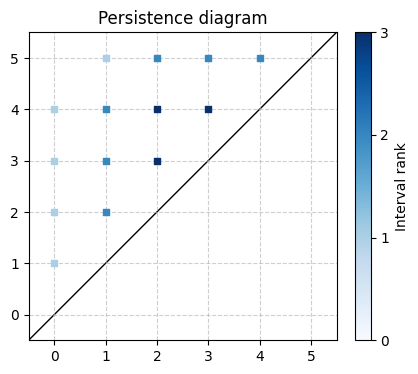

In [19]:
if not R.has_symbols():
    if R.dimensions[0] > 2:
        raise ValueError("Can only visualize when the underlying grid is a horizontal line or a horizontal commutative ladder.")
    elif R.dimensions[0] == 1:
        plot_items = []
        mult_list = []
        all_coords = []
        for itv in intervals:
            int_rank_sp = R.int_rank(itv, compression='ss')
            if int_rank_sp == 0:
                continue
            int_rank = float(int_rank_sp)
            geom_res = R.dot_line_trans(itv)
            if not geom_res:
                continue
            mult_list.append(int_rank)

            raw_x, raw_y = geom_res[0]
            swapped_data = (raw_y, raw_x)

            plot_items.append({'type': 'dot', 'data': swapped_data, 'mult': int_rank})
            all_coords.extend(swapped_data)

        fig, ax = plt.subplots(figsize=(6, 4))
        if mult_list:
            if all_coords:
                g_min = min(all_coords) - 0.5
                g_max = max(all_coords) + 0.5
                limit_min = g_min 
                limit_max = g_max
                ax.set_xlim(limit_min, limit_max)
                ax.set_ylim(limit_min, limit_max)
                ax.plot([limit_min, limit_max], [limit_min, limit_max], color='black', linestyle='-', linewidth=1, zorder=1, label='Diagonal')

                min_mult = min(mult_list)
                max_mult = max(mult_list)
                if min_mult < 0:
                    raise ValueError("An error occurs due to negative interval ranks.")
                else:
                    norm = mcolors.Normalize(vmin=0, vmax=max_mult)
                    cmap = cm.Blues

                for p in plot_items:
                    color = cmap(norm(p['mult']))
                    x, y = p['data']
                    ax.scatter(x, y, color=color, s=20, marker='s', zorder=5)

                sm = cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
                cbar.set_label('Interval rank')
                cbar.locator = MaxNLocator(integer=True) 
                cbar.update_ticks()

                ax.set_title('Persistence diagram')
                ax.grid(True, linestyle='--', alpha=0.6)
                ax.set_aspect('equal')

                plt.show()
    else:
        plot_items = []
        mult_list = []
        all_coords = []
        for itv in intervals:
            int_rank_sp = R.int_rank(itv, compression='ss')
            if int_rank_sp == 0:
                continue
            int_rank = float(int_rank_sp)
            geom_res = R.dot_line_trans(itv)
            if not geom_res:
                continue
            mult_list.append(int_rank)

            if len(geom_res) == 1:
                plot_items.append({'type': 'dot', 'data': geom_res[0], 'mult': int_rank})
                all_coords.extend(geom_res[0])
            elif len(geom_res) == 2:
                plot_items.append({'type': 'segment', 'data': geom_res, 'mult': int_rank})

                all_coords.extend(geom_res[0])
                all_coords.extend(geom_res[1])
            
        fig, ax = plt.subplots(figsize=(6, 4))
        if mult_list:
            if all_coords:
                g_min = min(all_coords) - 0.5
                g_max = max(all_coords) + 0.5
                # Add padding so points aren't on the edge
                pad = 0
                limit_min = g_min - pad
                limit_max = g_max + pad
                # Force both axes to have the EXACT same limits
                ax.set_xlim(limit_min, limit_max)
                ax.set_ylim(limit_min, limit_max)
                # --- Plot Diagonal across the entire square frame ---
                # From (min, min) to (max, max)
                ax.plot([limit_min, limit_max], [limit_min, limit_max], 
                        color='black', linestyle='-', linewidth=1, zorder=1, label='Diagonal')

            norm = mcolors.Normalize(vmin= 0, vmax=max(mult_list)) # Set color mapping
            cmap = cm.Blues

            # Plotting
            for p in plot_items:
                color = cmap(norm(p['mult']))
                if p['type'] == 'dot':
                        x, y = p['data']
                        ax.scatter(x, y, color=color, s=20, marker='s', zorder=5)
                elif p['type'] == 'segment':
                    (x0, y0), (x1, y1) = p['data']
                    ax.plot([x0, x1], [y0, y1], color=color, linewidth=1.5, markersize=4, zorder=4)
            # Add Colorbar
            sm = cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Interval rank')
            # Force ticks to be integers only (no 1.5, 2.5 etc.)
            # nbins='auto' will try to find a nice step size automatically
            cbar.locator = MaxNLocator(integer=True) 
            cbar.update_ticks()
            ax.set_title('Connected persistence diagram')
            ax.grid(True, linestyle='--', alpha=0.6)  # Control the visability of the grid
            ax.set_aspect('equal')
            plt.show()

As a remark, we note that all the endpoints and dots in the diagram represent a half-open, half-closed interval. For instance, in a connected persistence diagram, dot $(1, 3)$ in blue represents an interval with ${\rm sc} = \{(1, 1)\}$ and ${\rm sk} = \{(1, 3-1)\}$ $\big($thus an interval supported on $\{(1, 1), (1, 2)\}\big)$; dot $(4, 2)$ in blue represents an interval with ${\rm sc} = \{(0, 2)\}$ and ${\rm sk} = \{(0, 4-1)\}$ $\big($thus an interval supported on $\{(0, 2), (0, 3)\}\big)$; segment with endpoints $(1, 3)$ and $(4, 2)$ represents an interval supported on $\{(1, 1), (1, 2)\} \sqcup \{(0, 2), (0, 3)\}$. In the standard persistence diagram, the dot $(1, 3)$ in blue represents an interval with ${\rm sc} = \{(0, 1)\}$ and ${\rm sk} = \{(0, 3-1)\}$ $\big($thus an interval supported on $\{(0, 1), (0, 2)\}\big)$. We will adopt this convention in the sequel.

### 2) Interval replacement

Now that we can compute interval ranks, we can compute the interval replacement of the representation. Again, we refer to **[3]** for the notations. 

In the implementation, we used the definition based on the Möbius inversion.

In [20]:
display(R.int_replacement(itv1, compression="ss"))

if R.has_symbols():
    print(f"Valid if λ ∉ {R.singularities}")

1

We can compute all the interval signed multiplicities and display the nonzero ones.

In [21]:
for itv in intervals:
        
    repl = R.int_replacement(itv, compression='ss')
    if repl != 0:
        print(f"Interval: src={itv.src}, snk={itv.snk}")
        print()
        display_interval(R,itv)
        print()
        print("Interval signed multiplicity:")
        print()
        print()
        sp.pprint(repl)
        if R.has_symbols():
            print(f"Valid if λ ∉ {R.singularities}")
        print("="*60)

Interval: src=[(0, 2)], snk=[(0, 4)]

.          .          X -------> X -------> X

Interval signed multiplicity:


1
Interval: src=[(0, 0)], snk=[(0, 3)]

X -------> X -------> X -------> X          .

Interval signed multiplicity:


1
Interval: src=[(0, 1)], snk=[(0, 4)]

.          X -------> X -------> X -------> X

Interval signed multiplicity:


1


We can summarize the result and visualize it by utilizing the connected persistence diagrams. We refer to [5] for details.

Note that the visualization can NOT be implemented for symbolic computation.

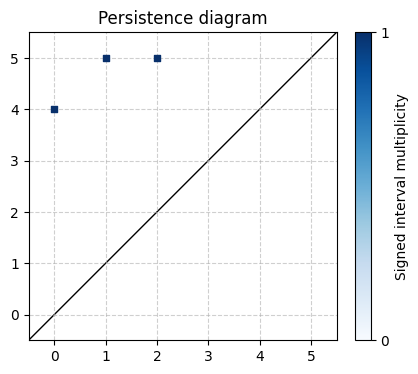

In [22]:
if not R.has_symbols():
    if R.dimensions[0] > 2:
        raise ValueError("Can only visualize when the underlying grid is a horizontal line or a horizontal commutative ladder.")
    elif R.dimensions[0] == 1:
        plot_items = []
        mult_list = []
        all_coords = []
        for itv in intervals:
            repl_sp = R.int_replacement(itv)
            if repl_sp == 0:
                continue
            repl = float(repl_sp)
            geom_res = R.dot_line_trans(itv)
            if not geom_res:
                continue
            mult_list.append(repl)

            raw_x, raw_y = geom_res[0]
            swapped_data = (raw_y, raw_x)

            plot_items.append({'type': 'dot', 'data': swapped_data, 'mult': repl})
            all_coords.extend(swapped_data)

        fig, ax = plt.subplots(figsize=(6, 4))
        if mult_list:
            if all_coords:
                g_min = min(all_coords) - 0.5
                g_max = max(all_coords) + 0.5
                limit_min = g_min 
                limit_max = g_max
                ax.set_xlim(limit_min, limit_max)
                ax.set_ylim(limit_min, limit_max)
                ax.plot([limit_min, limit_max], [limit_min, limit_max], color='black', linestyle='-', linewidth=1, zorder=1, label='Diagonal')

                min_mult = min(mult_list)
                max_mult = max(mult_list)
                if min_mult < 0:
                    raise ValueError("An error occurs due to negative signed multiplicities.")
                else:
                    norm = mcolors.Normalize(vmin=0, vmax=max_mult)
                    cmap = cm.Blues

                for p in plot_items:
                    color = cmap(norm(p['mult']))
                    x, y = p['data']
                    ax.scatter(x, y, color=color, s=20, marker='s', zorder=5)

                sm = cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
                cbar.set_label('Signed interval multiplicity')
                cbar.locator = MaxNLocator(integer=True) 
                cbar.update_ticks()

                ax.set_title('Persistence diagram')
                ax.grid(True, linestyle='--', alpha=0.6)
                ax.set_aspect('equal')

                plt.show()
    else:
        plot_items = []
        mult_list = []
        all_coords = []
        for itv in intervals:
            repl_sp = R.int_replacement(itv, compression='ss') # ss can be changed to tot
            if repl_sp == 0:
                continue
            repl = float(repl_sp)
            geom_res = R.dot_line_trans(itv)
            if not geom_res:
                continue
            mult_list.append(repl)

            if len(geom_res) == 1:
                plot_items.append({'type': 'dot', 'data': geom_res[0], 'mult': repl})
                all_coords.extend(geom_res[0])
            elif len(geom_res) == 2:
                plot_items.append({'type': 'segment', 'data': geom_res, 'mult': repl})

                all_coords.extend(geom_res[0])
                all_coords.extend(geom_res[1])
            
        fig, ax = plt.subplots(figsize=(6, 4))
        if mult_list:
            if all_coords:
                g_min = min(all_coords) - 0.5
                g_max = max(all_coords) + 0.5
                # Add padding so points aren't on the edge
                pad = 0
                limit_min = g_min - pad
                limit_max = g_max + pad
                # Force both axes to have the EXACT same limits
                ax.set_xlim(limit_min, limit_max)
                ax.set_ylim(limit_min, limit_max)
                # --- Plot Diagonal across the entire square frame ---
                # From (min, min) to (max, max)
                ax.plot([limit_min, limit_max], [limit_min, limit_max], 
                        color='black', linestyle='-', linewidth=1, zorder=1, label='Diagonal')

            # Set Colormap and Norm dynamically
            min_mult = min(mult_list)
            max_mult = max(mult_list)

            if min_mult < 0:
                abs_limit = max(abs(min_mult), abs(max_mult))
                norm = mcolors.Normalize(vmin=-abs_limit, vmax=abs_limit)
                cmap = cm.RdBu
            else:
                norm = mcolors.Normalize(vmin=0, vmax=max_mult)
                cmap = cm.Blues
            
            # Plotting
            for p in plot_items:
                color = cmap(norm(p['mult']))
                if p['type'] == 'dot':
                        x, y = p['data']
                        ax.scatter(x, y, color=color, s=20, marker='s', zorder=5)
                elif p['type'] == 'segment':
                    (x0, y0), (x1, y1) = p['data']
                    ax.plot([x0, x1], [y0, y1], color=color, linewidth=1.5, markersize=4, zorder=4)
            # Add Colorbar
            sm = cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Signed interval multiplicity')
            # Force ticks to be integers only (no 1.5, 2.5 etc.)
            # nbins='auto' will try to find a nice step size automatically
            cbar.locator = MaxNLocator(integer=True) 
            cbar.update_ticks()
            ax.set_title('Connected persistence diagram')
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_aspect('equal')
            plt.show()

### 3) Interval multiplicity

In this section, we demonstrate how to compute interval multiplicities, how to find the maximal interval-decomposable summand, and how to determine the interval-decomposability. We refer to [4] for theoretical backgrounds.

In [23]:
itv_sum_dim = 0

for itv in intervals:
    itv_mult = R.int_mult(itv)
    itv_dim = R.int_dim(itv)

    if itv_mult != 0: 
        print(f"Interval: src={itv.src}, snk={itv.snk}")
        print()
        display_interval(R, itv)
        print()
        print("Interval multiplicity:")
        print()
        print()
        sp.pprint(itv_mult)
        if R.has_symbols():
            print(f"Valid if λ ∉ {R.singularities}")
        print("="*120)
        itv_sum_dim = itv_sum_dim + itv_mult * itv_dim

if not R.has_symbols():
    if itv_sum_dim == 0:
        print("The input representation (persistence module) has no interval summand, hence it is NOT interval-decomposable.")
    elif itv_sum_dim == R.dim():
        print("The input representation (persistence module) is interval-decomposable. All interval summands are listed above.")
    else:
        print("The input representation (persistence module) is NOT interval-decomposable. All interval summands are listed above.")

print("="*120)

Interval: src=[(0, 2)], snk=[(0, 4)]

.          .          X -------> X -------> X

Interval multiplicity:


1
Interval: src=[(0, 0)], snk=[(0, 3)]

X -------> X -------> X -------> X          .

Interval multiplicity:


1
Interval: src=[(0, 1)], snk=[(0, 4)]

.          X -------> X -------> X -------> X

Interval multiplicity:


1
The input representation (persistence module) is interval-decomposable. All interval summands are listed above.


We can summarize the result and visualize it by utilizing the connected persistence diagrams. We refer to [5] for details.

Note that the visualization can NOT be implemented for symbolic computation.

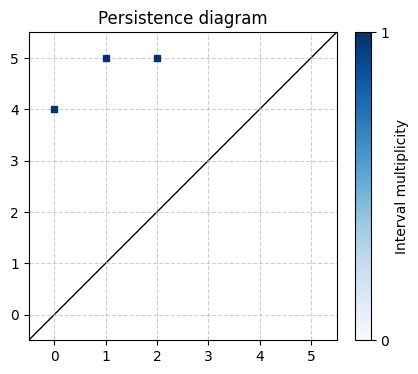

In [25]:
if not R.has_symbols():
    if R.dimensions[0] > 2:
        raise ValueError("Can only visualize when the underlying grid is a horizontal line or a horizontal commutative ladder.")
    elif R.dimensions[0] == 1:
        plot_items = []
        mult_list = []
        all_coords = []
        for itv in intervals:
            int_mult_sp = R.int_mult(itv)
            if int_mult_sp == 0:
                continue
            int_mult = float(int_mult_sp)
            geom_res = R.dot_line_trans(itv)
            if not geom_res:
                continue
            mult_list.append(int_mult)

            raw_x, raw_y = geom_res[0]
            swapped_data = (raw_y, raw_x)

            plot_items.append({'type': 'dot', 'data': swapped_data, 'mult': int_mult})
            all_coords.extend(swapped_data)

        fig, ax = plt.subplots(figsize=(6, 4))
        if mult_list:
            if all_coords:
                g_min = min(all_coords) - 0.5
                g_max = max(all_coords) + 0.5
                limit_min = g_min 
                limit_max = g_max
                ax.set_xlim(limit_min, limit_max)
                ax.set_ylim(limit_min, limit_max)
                ax.plot([limit_min, limit_max], [limit_min, limit_max], color='black', linestyle='-', linewidth=1, zorder=1, label='Diagonal')

                min_mult = min(mult_list)
                max_mult = max(mult_list)
                if min_mult < 0:
                    raise ValueError("An error occurs due to negative multiplicities.")
                else:
                    norm = mcolors.Normalize(vmin=0, vmax=max_mult)
                    cmap = cm.Blues

                for p in plot_items:
                    color = cmap(norm(p['mult']))
                    x, y = p['data']
                    ax.scatter(x, y, color=color, s=20, marker='s', zorder=5)

                sm = cm.ScalarMappable(cmap=cmap, norm=norm)
                sm.set_array([])
                cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
                cbar.set_label('Interval multiplicity')
                cbar.locator = MaxNLocator(integer=True) 
                cbar.update_ticks()

                ax.set_title('Persistence diagram')
                ax.grid(True, linestyle='--', alpha=0.6)
                ax.set_aspect('equal')

                plt.show()
    else:
        plot_items = []
        mult_list = []
        all_coords = []
        for itv in intervals:
            int_mult_sp = R.int_mult(itv)
            if int_mult_sp == 0:
                continue
            int_mult = float(int_mult_sp)
            geom_res = R.dot_line_trans(itv)
            if not geom_res:
                continue
            mult_list.append(int_mult)

            if len(geom_res) == 1:
                plot_items.append({'type': 'dot', 'data': geom_res[0], 'mult': int_mult})
                all_coords.extend(geom_res[0])
            elif len(geom_res) == 2:
                plot_items.append({'type': 'segment', 'data': geom_res, 'mult': int_mult})

                all_coords.extend(geom_res[0])
                all_coords.extend(geom_res[1])
            
        if mult_list:
            fig, ax = plt.subplots(figsize=(6, 4))
            if all_coords:
                g_min = min(all_coords) - 0.5
                g_max = max(all_coords) + 0.5
                # Add padding so points aren't on the edge
                pad = 0
                limit_min = g_min - pad
                limit_max = g_max + pad
                # Force both axes to have the EXACT same limits
                ax.set_xlim(limit_min, limit_max)
                ax.set_ylim(limit_min, limit_max)
                # --- Plot Diagonal across the entire square frame ---
                # From (min, min) to (max, max)
                ax.plot([limit_min, limit_max], [limit_min, limit_max], 
                        color='black', linestyle='-', linewidth=1, zorder=1, label='Diagonal')

            norm = mcolors.Normalize(vmin= 0, vmax=max(mult_list)) # Set color mapping
            cmap = cm.Blues

            # Plotting
            for p in plot_items:
                color = cmap(norm(p['mult']))
                if p['type'] == 'dot':
                        x, y = p['data']
                        ax.scatter(x, y, color=color, s=10, marker='s', zorder=5)
                elif p['type'] == 'segment':
                    (x0, y0), (x1, y1) = p['data']
                    ax.plot([x0, x1], [y0, y1], color=color, linewidth=1.5, markersize=4, zorder=4)
            # Add Colorbar
            sm = cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Interval multiplicity')
            # Force ticks to be integers only (no 1.5, 2.5 etc.)
            # nbins='auto' will try to find a nice step size automatically
            cbar.locator = MaxNLocator(integer=True) 
            cbar.update_ticks()
            ax.set_title('Connected persistence diagram')
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_aspect('equal')
            plt.show()
        else:
            print("The input representation (persistence module) has no interval summand, hence it is NOT interval-decomposable.")

## References

**[1]**: Asashiba, H., Buchet, M., Escolar, E. G., Nakashima, K., & Yoshiwaki, M. *On interval decomposability of 2D persistence modules*, Computational Geometry, Volumes 105–106, 2022, 101879, ISSN 0925-7721, [https://doi.org/10.1016/j.comgeo.2022.101879](https://doi.org/10.1016/j.comgeo.2022.101879).

**[2]**: Asashiba, H., Escolar, E. G., Nakashima, K., & Yoshiwaki, M. *On Approximation of 2D Persistence Modules by Interval-decomposables*. Journal of Computational Algebra, Volumes 6–7, 2023, 100007, ISSN 2772-8277, [https://doi.org/10.1016/j.jaca.2023.100007](https://doi.org/10.1016/j.jaca.2023.100007).

**[3]**: Asashiba, H., Gauthier, E., & Liu, E. *Interval Replacements of Persistence Modules*. arXiv preprint [arXiv:2403.08308](https://arxiv.org/abs/2403.08308) (2024).

**[4]**: Asashiba, H., & Liu, E. *Interval Multiplicities of Persistence Modules*. arXiv preprint [arXiv:2411.11594](
https://doi.org/10.48550/arXiv.2411.11594) (2024).

**[5]**: Hiraoka, Y., Nakashima, K., Obayashi, I., & Xu, C. *Refinement of interval approximations for fully commutative quivers*. Japan Journal of Industrial and Applied Mathematics, Volumes 42, Issue 4, 1309-1361 (2025), [https://doi.org/10.1007/s13160-025-00739-w](https://doi.org/10.1007/s13160-025-00739-w).

**[6]**: Kim, W., & Mémoli, F. *Generalized persistence diagrams for persistence modules over posets*. J Appl. and Comput. Topology 5, 533–581 (2021). [https://doi.org/10.1007/s41468-021-00075-1](https://doi.org/10.1007/s41468-021-00075-1).